# Computer Vision Workshop

TODO: Beschreibung hier.

In [1]:
%matplotlib inline

## Data preparation

Das Verzeichnis data enthält die Trainings- und Validierungsdaten aus dem Dataset. Dabei sind die Bilder zu jeder zu erkennenden "Klasse" (Cats & Dogs in unserem Fall) in einem eigenen Unterverzeichnis abgelegt:

In [18]:
# ! führt einen Shell-Befehl aus...
!tree -d data 

data
├── results
├── test
│   └── unknown
├── train
│   ├── cats
│   └── dogs
└── valid
    ├── cats
    └── dogs

9 directories


Mal schauen, wieviele Dateien in den Trainings- und Validerungsdaten drin sind:

In [21]:
!echo -n "Training cats:" && ls data/train/cats | wc -w
!echo -n "Training dogs:" && ls data/train/dogs | wc -w
!echo -n "Validation cats:" && ls data/valid/cats | wc -w
!echo -n "Validation dogs:" && ls data/valid/dogs | wc -w

Training cats:11567
Training dogs:11433
Validation cats:933
Validation dogs:1067


Das Verzeichnis "test" enthält die Bilder, die nicht klassifizert sind (deshalb Unterverzeichnis "unknown"). Diese wollen wir nach dem Training bestimmen. Mal sehen, wieviele das sind:

In [20]:
!echo -n "Test:" && ls data/test/unknown | wc -w

Test:12500


Damit wir am Code herumprobieren können, ohne gleich lange Laufzeiten aufgrund der vielen Dateien zu erhalten, gibt es noch ein "sample" Dataset, welches gleich aufgebaut ist, aber nur nur einen kleinen Teil der Daten enthält:

In [22]:
!tree -d sample

sample
├── results
├── test
│   └── unknown
├── train
│   ├── cats
│   └── dogs
└── valid
    ├── cats
    └── dogs

9 directories


In [23]:
!echo -n "Training cats:" && ls sample/train/cats | wc -w
!echo -n "Training dogs:" && ls sample/train/dogs | wc -w
!echo -n "Validation cats:" && ls sample/valid/cats | wc -w
!echo -n "Validation dogs:" && ls sample/valid/dogs | wc -w
!echo -n "Test:" && ls sample/test/unknown | wc -w

Training cats:100
Training dogs:100
Validation cats:25
Validation dogs:25
Test:25


## Training

In [3]:
from glob import glob
import numpy as np
import shutil
import os.path
# from __future__ import division,print_function

#import os, json
import numpy as np
#import time
np.set_printoptions(precision=4, linewidth=100)
# from matplotlib import pyplot as plt
#import utils; reload(utils)
#from utils import plots



Hier setzen wir den Pfad für die Daten, mit denen wir arbeiten wollen (also "data" oder "sample"):

In [4]:
# path = "data/"
path = "sample/"
path = os.path.join(os.path.curdir,path)
print path

./sample/


Wir laden die Python Klasse, welche das Modell (ein CNN) in ein nettes, mehr oder weniger objektorientiertes API verpackt. Der Sourcecode dazu steht in der Datei vgg16.py.

In [5]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size=64

# Wie viele Durchläufe durch die Trainingsdaten sollen gemacht werden:
epochs = 1

# Import VGG16 class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16
vgg = Vgg16()

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [6]:
# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [9]:
#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.01

results_path = '{}results'.format(path)
for epoch in range(1,epochs+1):
    print 'fit epoch {}'.format(epoch)
    vgg.fit(batches, val_batches, nb_epoch=1)
    weights_filename = '{}/vgg_weights-{}.h5'.format(results_path,epoch)
    print 'saving weights to {}'.format(weights_filename)
    vgg.model.save_weights(weights_filename)


fit epoch 1
Epoch 1/1
200/200 [==============================] - 9s - loss: 0.2907 - acc: 0.9650 - val_loss: 0.0193 - val_acc: 0.9800
saving weights to ./sample/results/vgg_weights-1.h5


## Prediction

Prediction Setup:

In [12]:
test_path = os.path.join(path,'test')
predictions_file = os.path.join(path,'results/predictions.dat')
filenames_file = os.path.join(path,'results/filenames.dat')

import utils
import time

Predict and save results:

In [13]:
print('start predicting at {}'.format(time.asctime()))
batches, predictions = vgg.test(test_path,batch_size=batch_size*2)
print('stop predicting at {}'.format(time.asctime()))

utils.save_array(predictions_file, predictions)
utils.save_array(filenames_file, batches.filenames)

start predicting at Tue Nov 21 16:10:14 2017
Found 25 images belonging to 1 classes.
stop predicting at Tue Nov 21 16:10:18 2017


[[  1.1227e-12   1.0000e+00]
 [  8.0743e-12   1.0000e+00]
 [  1.1038e-08   1.0000e+00]
 [  1.0000e+00   9.2580e-39]
 [  1.9459e-11   1.0000e+00]]
['unknown/11519.jpg', 'unknown/8733.jpg', 'unknown/12168.jpg', 'unknown/7464.jpg', 'unknown/11753.jpg']


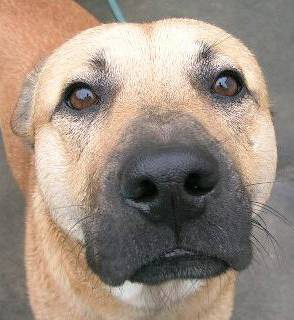

In [17]:
print(predictions[:5])
print(batches.filenames[:5])
from PIL import Image
Image.open(os.path.join(test_path,batches.filenames[-1]))



## Visualize

Wir wollen uns auch anschauen, wie gut unser Modell eigentlich vorhersagt. Die Idee ist, dass wir mit dem Modell eine Vorhersage über die bereits klassifizierten Trainingsdaten machen. So kennen wir die "ground truth" zu jedem Bild und können ermitteln, ob die Vorhersage korrekt war.

In [4]:
if not 'path' in locals():
    # path = "data/redux/sample/"
    path = "data/redux/"

#import numpy as np
#import utils; reload(utils)
#import vgg16; reload(vgg16)
#from vgg16 import Vgg16

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


Load the trained weights into the model

In [5]:
vgg = Vgg16()

weights_filename = '{path}results/vgg_weights-{epoch}.h5'.format(path=path,epoch=1)
vgg.model.load_weights(weights_filename)

Predict the validation data. This way we know the ground truth and are able to compare it with the predictions of our model.

In [6]:
valid_batches, predictions = vgg.test(path+'valid', batch_size=64)
expected_labels = valid_batches.classes
filenames = valid_batches.filenames

print predictions[:8]

our_predictions = predictions[:,0]
our_labels = np.round(1-our_predictions)
print our_labels[:8]

Found 2000 images belonging to 2 classes.
[[  1.0000e+00   0.0000e+00]
 [  1.0000e+00   0.0000e+00]
 [  9.2621e-14   1.0000e+00]
 [  1.0000e+00   0.0000e+00]
 [  1.0000e+00   0.0000e+00]
 [  1.0000e+00   0.0000e+00]
 [  1.0000e+00   0.0000e+00]
 [  1.0000e+00   0.0000e+00]]
[ 0.  0.  1.  0.  0.  0.  0.  0.]


In [7]:
from keras.preprocessing import image
def plots_idx(idx, titles=None):
    utils.plots([image.load_img(path+'valid/'+filenames[i]) for i in idx], titles=titles)

### Display some correct labels

Found 1958 correct labels


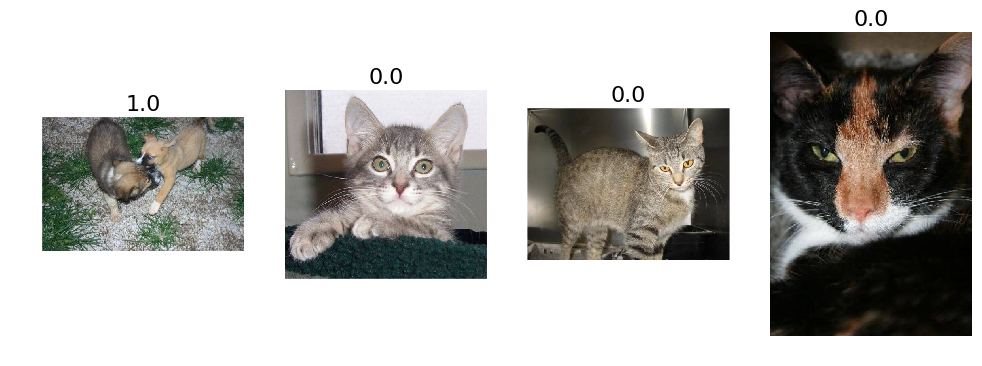

In [11]:
correct = np.where(our_labels==expected_labels)[0]
print "Found {} correct labels".format(len(correct))
idx = np.random.permutation(correct)[:4]
plots_idx(idx, our_labels[idx])

### Display some incorrect labels

Found 42 incorrect labels.


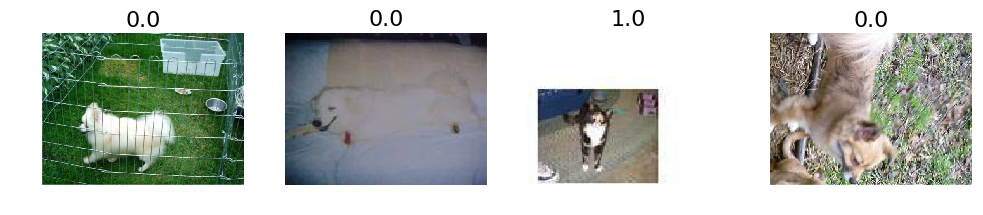

In [13]:
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found {} incorrect labels.".format(len(incorrect))
idx = np.random.permutation(incorrect)[:4]
plots_idx(idx,our_labels[idx])

### Display most confident correct labels (i.e. where we've been really right)

Found 971 confident correct cats labels
Found 987 confident correct dogs labels


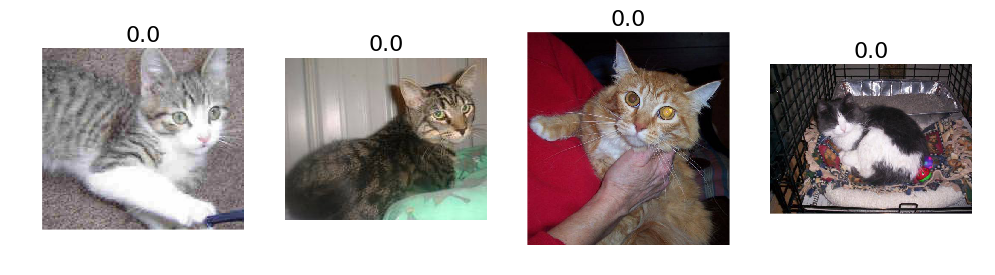

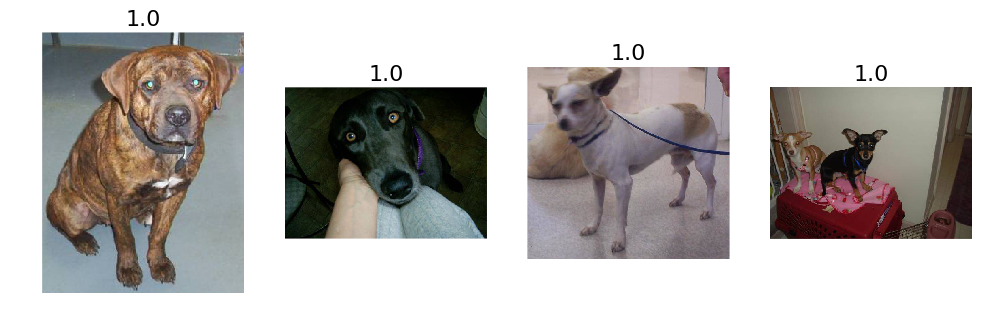

In [15]:
confident_cats = np.where((our_labels==expected_labels) & (our_labels==0))[0]
print "Found {} confident correct cats labels".format(len(confident_cats))
idx = np.random.permutation(confident_cats)[:4]
plots_idx(idx,our_labels[idx])

confident_dogs = np.where((our_labels==expected_labels) & (our_labels==1))[0]
print "Found {} confident correct dogs labels".format(len(confident_dogs))
idx = np.random.permutation(confident_dogs)[:4]
plots_idx(idx,our_labels[idx])

### Display most confident incorrect labels (i.e. where we've been really wrong)

Found 23 confident incorrect cats labels
Found 19 confident incorrect cats labels


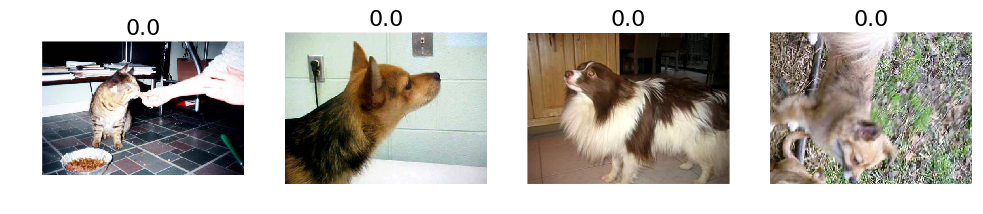

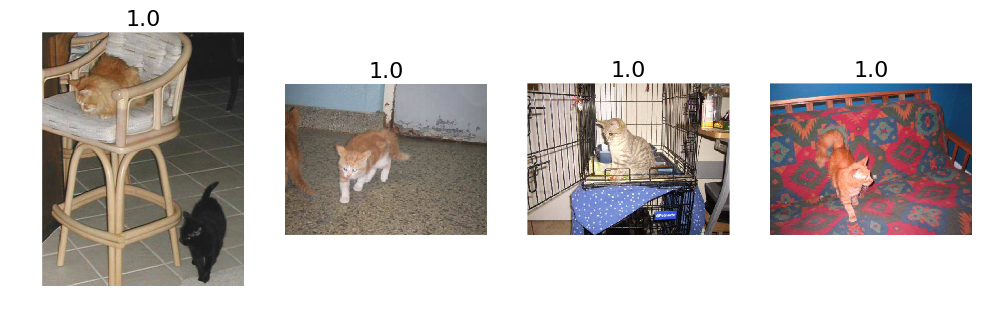

In [10]:
confident_cats = np.where((our_labels!=expected_labels) & (our_labels==0))[0]
print "Found {} confident incorrect cats labels".format(len(confident_cats))
idx = np.random.permutation(confident_cats)[:4]
plots_idx(idx,our_labels[idx])

confident_dogs = np.where((our_labels!=expected_labels) & (our_labels==1))[0]
print "Found {} confident incorrect cats labels".format(len(confident_dogs))
idx = np.random.permutation(confident_dogs)[:4]
plots_idx(idx,our_labels[idx])

### Display most uncertain labels

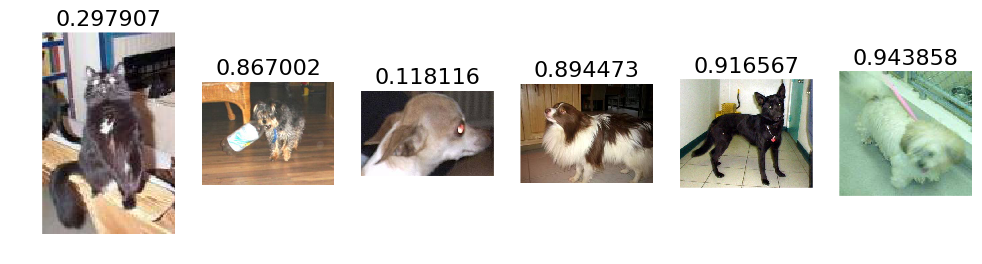

In [18]:
uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(uncertain[:6],our_predictions[uncertain])

### Confusion Matrix

[[971  19]
 [ 23 987]]


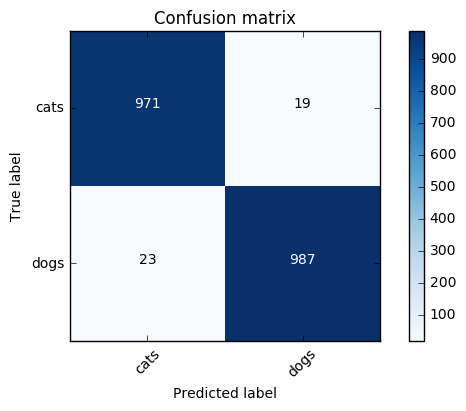

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels,our_labels)
utils.plot_confusion_matrix(cm, valid_batches.class_indices)